# Transit Timing Variations
This example uses ``celmech``'s Lie transfromation capabilities to compute the TTVs of a planet in a two-planet system.  The first part of this example is taken directly from the ``rebound`` example [here](https://github.com/hannorein/rebound/blob/main/ipython_examples/TransitTimingVariations.ipynb). The second part shows how to do a similar calculation analytically with ``celmech``.

# Calculating Transit Timing Variations (TTV) with REBOUND
The following code finds the transit times in a two planet system. The transit times of the inner planet are not exactly periodic, due to planet-planet interactions.

First, let's import the REBOUND and numpy packages.

In [1]:
import rebound
import numpy as np

Let's set up a coplanar two planet system.

In [2]:
def get_sim():
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(m=1e-5, P=1,e=0.05,pomega=0.25)
    sim.add(m=1e-5, P=1.5 * (1+0.02), e=0.03,pomega = 4.1,l=np.pi/2)
    sim.move_to_com()
    return sim

We're now going to integrate the system forward in time. We assume the observer of the system is in the direction of the positive x-axis. We want to meassure the time when the inner planet transits. In this geometry, this happens when the y coordinate of the planet changes sign. Whenever we detect a change in sign between two steps, we try to find the transit time, which must lie somewhere within the last step, by bisection. 

In [3]:
N=174
sim = get_sim()
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[1].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit 

/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


Next, we do a linear least square fit to remove the linear trend from the transit times, thus leaving us with the transit time variations.

In [4]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes,rcond=-1)[0]

Finally, let us plot the TTVs.

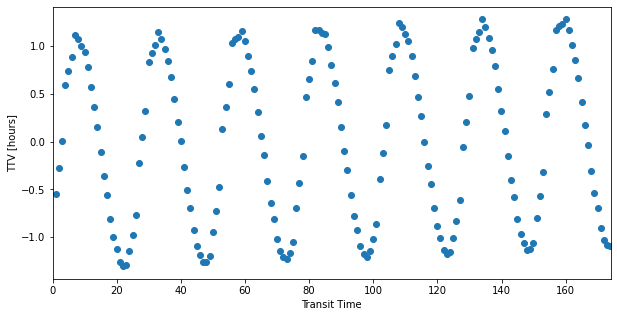

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit Time")
ax.set_ylabel("TTV [hours]")
plt.scatter(transittimes, (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));

# TTVs with ``celmech``

In [6]:
from celmech import Poincare
from celmech.lie_transformations import FirstOrderGeneratingFunction
#from celmech.miscellaneous import 
import sympy
sympy.init_printing()
from sympy import symbols,cos,sin

In [7]:
pvars = Poincare.from_Simulation(get_sim())
chi = FirstOrderGeneratingFunction(pvars)
for j in range(2,5):
    chi.add_MMR_terms(j,1,1,l_max=1)
chi.add_zeroth_order_term()

# Convert variables to mean values
chi.osculating_to_mean()

# get relevant variables
ps = chi.particles[1:]
l = sympy.symbols("lambda(1:3)")
eta = sympy.symbols("eta(1:3)")
kappa = sympy.symbols("kappa(1:3)")
H = [eta[i]/np.sqrt(ps[i].Lambda) for i in range(2)]
K = [kappa[i]/np.sqrt(ps[i].Lambda) for i in range(2)]

# Expression for theta
theta = [l[i] + 2 * H[i] * cos(l[i]) + 2 * K[i] * sin(l[i]) for i in range(2)]

# Solution for theta
dtheta_func = chi.get_perturbative_solution(theta[0],correction_only=True,lambdify=True)

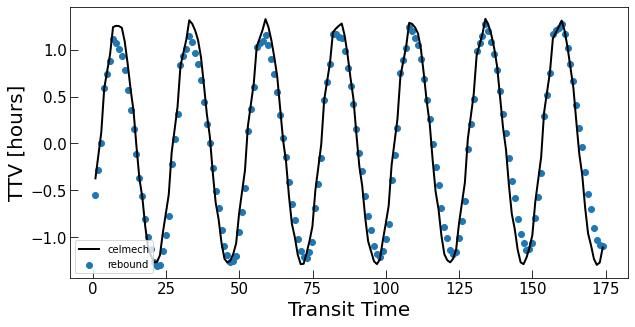

In [8]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

plt.plot(transittimes,- (24.*365./2./np.pi) * ps[0].P * dtheta_func(transittimes) / (2*np.pi),color='k',lw=2,label='celmech')
plt.scatter(transittimes, (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi),label='rebound');
plt.legend()
ax.set_xlabel("Transit Time",fontsize=20)
ax.set_ylabel("TTV [hours]",fontsize=20)
plt.tick_params(direction='in',size=8,labelsize=15)